<a href="https://colab.research.google.com/github/sarathkumar000/Datasets/blob/master/ModelFitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, roc_curve, auc, roc_auc_score, 
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from google.colab import files
import pandas as pd
import io
import time

NumPy 1.17.5
SciPy 1.4.1
Scikit-Learn 0.22.1


In [0]:
uploaded = files.upload()
df1 = pd.read_csv(io.StringIO(uploaded['clean.csv'].decode('cp1252')),)
df1.head()


Saving clean.csv to clean (1).csv


,Unnamed: 0,Valid,Review
0,0,1.0,something definitely wrong get touch vet take ...
1,1,1.0,shaking often sign pain distress mental physic...
2,2,0.0,time tell u take vet
3,3,0.0,happy new year l take tall glass bubbly please
4,4,0.0,happy new year otis blurted family raise glass...


In [0]:
output = pd.DataFrame(columns=['X', 'Y'])
df1.dropna() 
def change(x):
  if x==11:
    return 1
  else:
    return x
x=df1['Review']
y=df1['Valid']
output['X']=x.copy()
output['Y']=y.copy()
#pd.options.display.float_format = '{:,.0f}'.format
output['Y'] = output['Y'].fillna(0.0).astype(int)
output['Y'] = output['Y'].apply(lambda x:change(x))
output.head()

,X,Y
0,something definitely wrong get touch vet take ...,1
1,shaking often sign pain distress mental physic...,1
2,time tell u take vet,0
3,happy new year l take tall glass bubbly please,0
4,happy new year otis blurted family raise glass...,0


In [0]:
print(output.groupby('Y').count())

       X
Y       
0  11952
1  12222


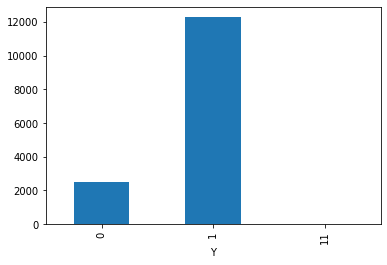

In [0]:
output.groupby("Y")['Y'].count().plot.bar()

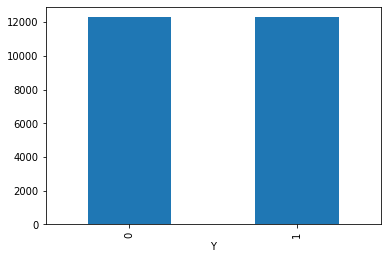

In [0]:
from sklearn.utils import resample

df_majority = output[output.Y==1]
df_minority = output[output.Y==0]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=9800,    # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
output = pd.concat([output, df_minority_upsampled])
output.groupby("Y")['Y'].count().plot.bar()
#output = output.sample(frac=1)
# Display new class counts
#df_upsampled.label.value_counts()

In [0]:
def BOW_vectorization():
    count_vectorizer = CountVectorizer()
    
    bow_text = count_vectorizer.fit_transform(output['X'].values.astype('U'))
    bow_feature_names = count_vectorizer.get_feature_names()
    #visualizations().plot_frequency_distribution(bow_text, bow_feature_names)
    #X = pd.DataFrame(bow_text.toarray(), columns = bow_feature_names)
    Y = output['Y']
    X=bow_text.toarray()
    #visualizations().plot_TSNE_distribution(bow_text, Y)
    return X, Y

def TFIDF_vectorization():
    tfidf_vectorizer = TfidfVectorizer(max_features = 5500)
    tfidf_text = tfidf_vectorizer.fit_transform(output['X'].values.astype('U'))
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    #visualizations().plot_frequency_distribution(tfidf_text, tfidf_feature_names)
    X = tfidf_text.toarray()
    #pd.DataFrame(tfidf_text.toarray(), columns = tfidf_feature_names)
    Y = output['Y']
    #visualizations().plot_TSNE_distribution(tfidf_text, Y)
    return X, Y

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
X1, Y1 =TFIDF_vectorization()
Y1.apply(lambda x:change(x))
print(type(X1))
svd = TruncatedSVD(algorithm='randomized',n_components=200, n_iter=7, random_state=None,tol=0.0)
X2=svd.fit_transform(X1)
print(type(X2))
Xtemp, Xtest, Ytemp, Ytest = train_test_split(X2, Y1, test_size = 0.2, random_state = 12)
Xtrain, Xcv, Ytrain, Ycv = train_test_split(Xtemp, Ytemp, test_size = 0.2, random_state = 12)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [0]:
print(len(X1))
print(len(Xtest))
print(len(Xtrain))
print(len(Xcv))

24578
4916
15729
3933


In [0]:
def decision_tree_classification(X,Y,depth):
    classifier = DecisionTreeClassifier(criterion='gini', splitter='best',  max_depth=depth, random_state=None, min_samples_split=2, min_samples_leaf=5, max_features=None)
    start_time = time.time()
    classifier.fit(Xtrain,Ytrain)
    predictions = classifier.predict(X)
    accuracy = accuracy_score(Y, predictions)
    elapsed_time = (time.time() - start_time)
    print('Decision Tree Classification :')
    print('Accuracy: {0}'.format(accuracy))
    print('Elapsed Time: {0}'.format(elapsed_time))
    confusionMatrix(Y, predictions)
    classificationReport(Y, predictions)
    plot_roc_auc_curve(Y, predictions)
    return accuracy

def random_forest_classification(X,Y,depth):
    classifier = RandomForestClassifier(
            criterion='gini', n_estimators=100, max_depth=depth, random_state=None, min_samples_split=2, min_samples_leaf=5, max_features=None
                                                  )
    start_time = time.time()
    classifier.fit(Xtrain, Ytrain)
    predictions = classifier.predict(X)
    accuracy = accuracy_score(Y, predictions)
    elapsed_time = (time.time() - start_time)
    print('Random Forest Classification :')
    print('Accuracy: {0}'.format(accuracy))
    print('Elapsed Time: {0}'.format(elapsed_time))
    confusionMatrix(Y, predictions)
    classificationReport(Y, predictions)
    plot_roc_auc_curve(Y, predictions)
    return accuracy
def knn_classification(X,Y,n):
    classifier = KNeighborsClassifier(n_neighbors=n, algorithm='auto',  n_jobs=None)
    start_time = time.time()
    classifier.fit(X, Y)
    predictions = classifier.predict(X)
    accuracy = accuracy_score(Y, predictions)
    elapsed_time = (time.time() - start_time)
    print('KNN Classification :')
    print('Accuracy: {0}'.format(accuracy))
    print('Elapsed Time: {0}'.format(elapsed_time))
    confusionMatrix(Y, predictions)
    #classificationReport(Y, predictions)
    #plot_roc_auc_curve(Y, predictions)
    return accuracy

def svm_classification(X,Y,c):
    classifier = SVC(kernel='linear', random_state=None, C=c, gamma=1.0)
    start_time = time.time()
    classifier.fit(X, Y)
    predictions = classifier.predict(X)
    accuracy = accuracy_score(Y, predictions)
    elapsed_time = (time.time() - start_time)
    print('SVM Classification :')
    print('Accuracy: {0}'.format(accuracy))
    print('Elapsed Time: {0}'.format(elapsed_time))
    #confusionMatrix(Y, predictions)
    #classificationReport(Y, predictions)
    #plot_roc_auc_curve(Y, predictions)
    return accuracy

In [0]:
def plot_roc_auc_curve( Ytest, Ypred):
    fpr, tpr, thresholds = roc_curve(Ytest, Ypred, pos_label =1)
    roc_auc = auc(fpr, tpr)
    auc_score = roc_auc_score(Ytest, Ypred)
    print('ROC score : {0}'.format(roc_auc))
    print('AUC score : {0}'.format(auc_score))
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange')
    plt.plot([0,1], [0,1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show() 

def plot_frequency_distribution(text, feature_names):
    visualizer = FreqDistVisualizer(features=feature_names)
    visualizer.fit(text)
    visualizer.poof()
  #  t-Distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction algorithm for visualizing high-dimensional datasets.
def plot_TSNE_distribution(text, labels):
    tsne = TSNEVisualizer()
    tsne.fit_transform(text, labels)
    tsne.poof()

In [0]:
def confusionMatrix(Ytest, Ypred):
    results = confusion_matrix(Ytest, Ypred)
    print('Confusion Matrix: {0}'.format(results))
    sns.heatmap(results, annot=True, cbar=False)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')


def classificationReport(Ytest, Ypred):
    report = classification_report(Ytest, Ypred)
    print('Classification report: {0}'.format(report))

In [0]:
import sys
sys.setrecursionlimit(10000)

In [0]:
decision_tree_classification(Xtrain,Ytrain,30)

Decision Tree Classification :
Accuracy: 0.9647148579057792
Elapsed Time: 4.432506084442139


0.9647148579057792

Decision Tree Classification :
Accuracy: 0.631762985568059
Elapsed Time: 0.6995394229888916
Decision Tree Classification :
Accuracy: 0.7584080361116409
Elapsed Time: 1.8200891017913818
Decision Tree Classification :
Accuracy: 0.8623561574162375
Elapsed Time: 2.7695577144622803
Decision Tree Classification :
Accuracy: 0.9136626613262128
Elapsed Time: 3.3233039379119873
Decision Tree Classification :
Accuracy: 0.9420179286667938
Elapsed Time: 3.767970561981201
Decision Tree Classification :
Accuracy: 0.957657829486935
Elapsed Time: 4.069438695907593
Decision Tree Classification :
Accuracy: 0.9642698200775638
Elapsed Time: 4.2357189655303955
Decision Tree Classification :
Accuracy: 0.9649055884035858
Elapsed Time: 4.367508172988892
Decision Tree Classification :
Accuracy: 0.9651598957339945
Elapsed Time: 4.429133176803589
Decision Tree Classification :
Accuracy: 0.9652234725665967
Elapsed Time: 4.451913833618164
Decision Tree Classification :
Accuracy: 0.9656685103948122
Elapsed Time: 4.4

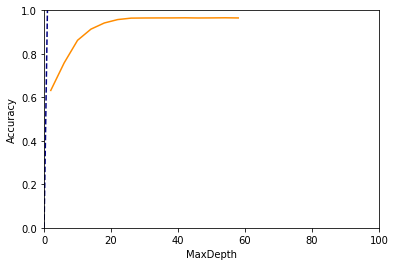

In [0]:
#ml_models = machine_learning_models(Xtrain, Xtest, Ytrain, Ytest)
x=[]
y=[]
for i in range(2,60,4):
  x.append(i)
  y.append(decision_tree_classification(Xtrain,Ytrain,i))
  #decision_tree_classification(Xtest,Ytest)
plt.figure()
plt.plot(x, y, color='darkorange')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlim([0, 100])
plt.ylim([0, 1])
plt.xlabel('MaxDepth')
plt.ylabel('Accuracy')
plt.show() 


Decision Tree Classification :
Accuracy: 0.9148232901093313
Elapsed Time: 4.692758321762085
Confusion Matrix: [[1828  112]
 [ 223 1770]]
Classification report:               precision    recall  f1-score   support

           0       0.89      0.94      0.92      1940
           1       0.94      0.89      0.91      1993

    accuracy                           0.91      3933
   macro avg       0.92      0.92      0.91      3933
weighted avg       0.92      0.91      0.91      3933

ROC score : 0.9151882102823801
AUC score : 0.9151882102823801


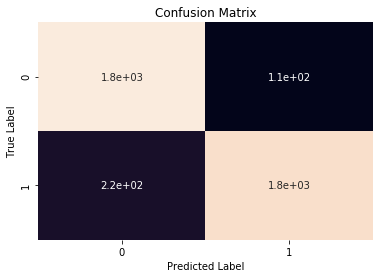

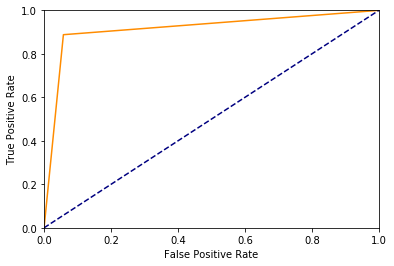

0.9148232901093313

In [0]:
decision_tree_classification(Xcv,Ycv,30)

Decision Tree Classification :
Accuracy: 0.9129373474369405
Elapsed Time: 4.357212543487549
Confusion Matrix: [[2287  143]
 [ 285 2201]]
Classification report:               precision    recall  f1-score   support

           0       0.89      0.94      0.91      2430
           1       0.94      0.89      0.91      2486

    accuracy                           0.91      4916
   macro avg       0.91      0.91      0.91      4916
weighted avg       0.91      0.91      0.91      4916

ROC score : 0.9132551341007584
AUC score : 0.9132551341007584


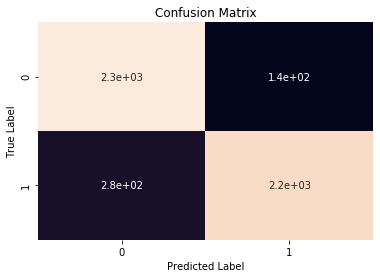

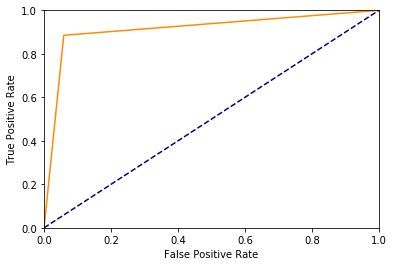

0.9129373474369405

In [0]:
decision_tree_classification(Xtest,Ytest,30)

In [0]:
x=[]
y=[]
for i in range(4,40,4):
  x.append(i)
  y.append(random_forest_classification(Xtrain,Ytrain,i))
  #decision_tree_classification(Xtest,Ytest)
plt.figure()
plt.plot(x, y, color='darkorange')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlim([0, 100])
plt.ylim([0, 1])
plt.xlabel('MaxDepth')
plt.ylabel('Accuracy')
plt.show() 



In [0]:
random_forest_classification(Xcv,Ycv,24)

Random Forest Classification :
Accuracy: 0.9576891781936534
Elapsed Time: 302.39598393440247
Confusion Matrix: [[2320  110]
 [  98 2388]]
Classification report:               precision    recall  f1-score   support

           0       0.96      0.95      0.96      2430
           1       0.96      0.96      0.96      2486

    accuracy                           0.96      4916
   macro avg       0.96      0.96      0.96      4916
weighted avg       0.96      0.96      0.96      4916

ROC score : 0.9576558770265752
AUC score : 0.9576558770265752


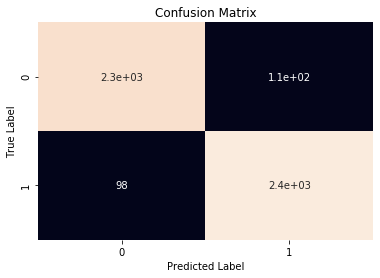

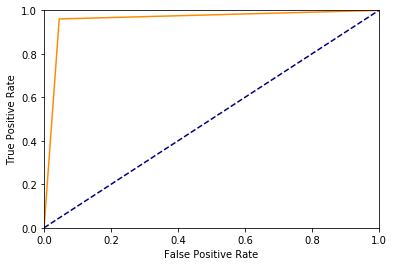

0.9576891781936534

In [0]:
random_forest_classification(Xtest,Ytest,24)

KNN Classification :
Accuracy: 0.9833428698582236
Elapsed Time: 1.9424021244049072
Confusion Matrix: [[7826   90]
 [ 172 7641]]
KNN Classification :
Accuracy: 0.9660499713904254
Elapsed Time: 46.55037569999695
Confusion Matrix: [[7821   95]
 [ 439 7374]]
KNN Classification :
Accuracy: 0.9434166189840422
Elapsed Time: 69.40448498725891
Confusion Matrix: [[7616  300]
 [ 590 7223]]
KNN Classification :
Accuracy: 0.9177951554453557
Elapsed Time: 88.47615432739258
Confusion Matrix: [[7335  581]
 [ 712 7101]]
KNN Classification :
Accuracy: 0.8984042215016848
Elapsed Time: 99.32425284385681
Confusion Matrix: [[7104  812]
 [ 786 7027]]
KNN Classification :
Accuracy: 0.8821921291881238
Elapsed Time: 103.17142057418823
Confusion Matrix: [[6820 1096]
 [ 757 7056]]
KNN Classification :
Accuracy: 0.8718926823065675
Elapsed Time: 108.43489265441895
Confusion Matrix: [[6697 1219]
 [ 796 7017]]
KNN Classification :
Accuracy: 0.8595587767817408
Elapsed Time: 116.29554772377014
Confusion Matrix: [[6456 

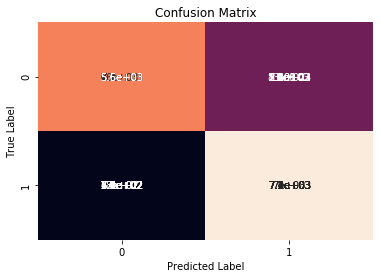

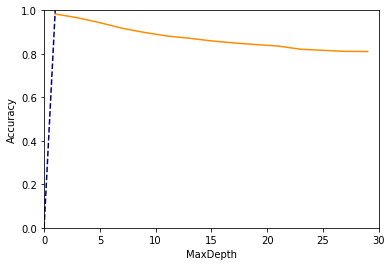

In [0]:
x=[]
y=[]
for i in range(1,30,2):
  x.append(i)
  y.append(knn_classification(Xtrain,Ytrain,i))
  #decision_tree_classification(Xtest,Ytest)
plt.figure()
plt.plot(x, y, color='darkorange')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlim([0, 30])
plt.ylim([0, 1])
plt.xlabel('MaxDepth')
plt.ylabel('Accuracy')
plt.show() 


KNN Classification :
Accuracy: 0.863208746503941
Elapsed Time: 6.727583646774292
Confusion Matrix: [[1586  354]
 [ 184 1809]]


0.863208746503941

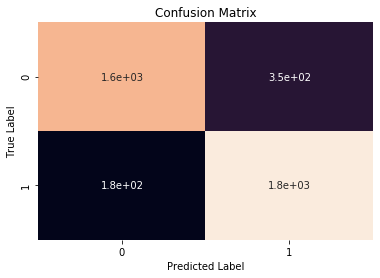

In [0]:
knn_classification(Xcv,Ycv,5)


KNN Classification :
Accuracy: 0.870626525630594
Elapsed Time: 8.906477451324463
Confusion Matrix: [[2034  396]
 [ 240 2246]]


0.870626525630594

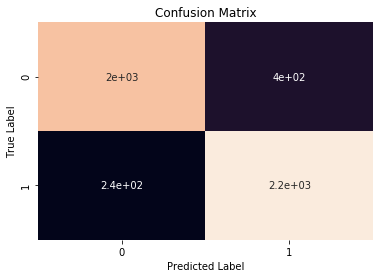

In [0]:
knn_classification(Xtest,Ytest,5)